In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import pandas as pd
import re
import numpy as np
from catboost import CatBoostClassifier

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
POSTGRES_USER = os.environ.get("POSTGRES_USER")
POSTGRES_PASSWORD = os.environ.get("POSTGRES_PASSWORD")
POSTGRES_HOST = os.environ.get("POSTGRES_HOST")
POSTGRES_PORT = os.environ.get("POSTGRES_PORT")
POSTGRES_DATABASE = os.environ.get("POSTGRES_DATABASE")

In [4]:
# Датасет по юзерам

#user_info = pd.read_csv('https://drive.google.com/uc?id=1dCRcm1SW7o_LftFD8F0UNQO59mYKsR7d')
user_info = pd.read_sql(
    """SELECT * FROM public.user_data""",
    
    con="postgresql://" + POSTGRES_USER + ":" + POSTGRES_PASSWORD + "@"
        + str(POSTGRES_HOST) + ":" + POSTGRES_PORT + "/" + POSTGRES_DATABASE)


user_info.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [5]:
# Датасет по постам

#posts_info = pd.read_csv('https://drive.google.com/uc?id=1K2clFp00Hp5pGHGiy7NRf0DT5zxGz15h')
posts_info = pd.read_sql(
    """SELECT * FROM public.post_text_df""",
    
    con="postgresql://" + POSTGRES_USER + ":" + POSTGRES_PASSWORD + "@"
        + str(POSTGRES_HOST) + ":" + POSTGRES_PORT + "/" + POSTGRES_DATABASE)

posts_info = posts_info.drop('text',axis=1)
posts_info.head()

,post_id,topic
0,1,business
1,2,business
2,3,business
3,4,business
4,5,business


In [6]:
# Файл большой, заранне скачать https://drive.google.com/file/d/1A8wzhuwz5NWjPNIBDK-7DFp6qXKTqtNk/view?usp=sharing
# feed_data = pd.read_csv('feed_data_ML.csv')

feed_data = pd.read_sql(
    """SELECT * FROM public.feed_data LIMIT 23100000 """,
    
    con="postgresql://" + POSTGRES_USER + ":" + POSTGRES_PASSWORD + "@"
        + str(POSTGRES_HOST) + ":" + POSTGRES_PORT + "/" + POSTGRES_DATABASE)


feed_data.head()

,timestamp,user_id,post_id,action,target
0,2021-10-31 07:12:19,130401,1463,view,0
1,2021-10-31 07:14:31,130401,1204,view,0
2,2021-10-31 07:15:14,130401,4448,view,0
3,2021-10-31 07:17:59,130401,4122,view,0
4,2021-10-31 07:18:28,130401,3158,view,0


In [7]:
# Оставляем только те где просмотр
feed_data = feed_data[feed_data.action=='view']
feed_data = feed_data.drop('action', axis=1)
feed_data.head()

,timestamp,user_id,post_id,target
0,2021-10-31 07:12:19,130401,1463,0
1,2021-10-31 07:14:31,130401,1204,0
2,2021-10-31 07:15:14,130401,4448,0
3,2021-10-31 07:17:59,130401,4122,0
4,2021-10-31 07:18:28,130401,3158,0


In [8]:
# Убираем лишние категориальные колонки
user_info = user_info.drop(['source', 'os', 'country'], axis=1)
user_info.head()

,user_id,gender,age,city,exp_group
0,200,1,34,Degtyarsk,3
1,201,0,37,Abakan,0
2,202,1,17,Smolensk,4
3,203,0,18,Moscow,1
4,204,0,36,Anzhero-Sudzhensk,3


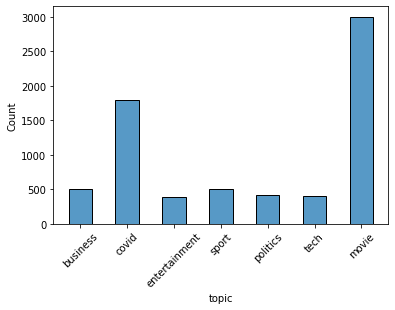

In [9]:
sns.histplot(posts_info.topic, shrink=0.5)
plt.xticks(rotation = 45)
plt.show()

In [10]:
# Соеденияем таблицы
df = pd.merge(feed_data,
              posts_info,
              on='post_id',
              how='left')
del posts_info

In [11]:
df = pd.merge(df,
              user_info,
              on='user_id',
              how='left')

df.head()
del user_info

In [12]:
df = df.drop(['user_id', 'post_id'],axis=1)

In [13]:
# Создаем фичи по времени 
df['hour'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.hour)
df['month'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.month)
df['day'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.day)
df.head()

,timestamp,target,topic,gender,age,city,exp_group,hour,month,day
0,2021-10-31 07:12:19,0,sport,1,21,Timashevsk,3,7,10,31
1,2021-10-31 07:14:31,0,politics,1,21,Timashevsk,3,7,10,31
2,2021-10-31 07:15:14,0,movie,1,21,Timashevsk,3,7,10,31
3,2021-10-31 07:17:59,0,covid,1,21,Timashevsk,3,7,10,31
4,2021-10-31 07:18:28,0,covid,1,21,Timashevsk,3,7,10,31


In [14]:
max(df.timestamp), min(df.timestamp)

('2021-12-29 23:44:39', '2021-10-01 06:02:14')

In [15]:
# Валидируем по времени
df_train = df[df.timestamp < '2021-12-15']
df_test = df[df.timestamp >= '2021-12-15']


df_train = df_train.drop('timestamp', axis=1)
df_test = df_test.drop('timestamp', axis=1)

X_train = df_train.drop('target', axis=1)
X_test = df_test.drop('target', axis=1)

y_train = df_train['target']
y_test = df_test['target']

y_train.shape, y_test.shape


((17190201,), (3450127,))

In [16]:
X_train.head()

,topic,gender,age,city,exp_group,hour,month,day
0,sport,1,21,Timashevsk,3,7,10,31
1,politics,1,21,Timashevsk,3,7,10,31
2,movie,1,21,Timashevsk,3,7,10,31
3,covid,1,21,Timashevsk,3,7,10,31
4,covid,1,21,Timashevsk,3,7,10,31


In [17]:
object_cols = ['topic', 'gender', 'city', 'exp_group', 'hour', 'month', 'day']

In [18]:
catboost = CatBoostClassifier(iterations=100,
                              learning_rate=1,
                              depth=2,
                              silent=True,
                              task_type='GPU',
                              random_seed=42)

catboost.fit(X_train, y_train, object_cols)

print(f"Качество на трейне: {roc_auc_score(y_train, catboost.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.6725197023237732
Качество на тесте: 0.6495589435631932


In [19]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    


In [20]:
catboost.save_model('model_control', format="cbm")

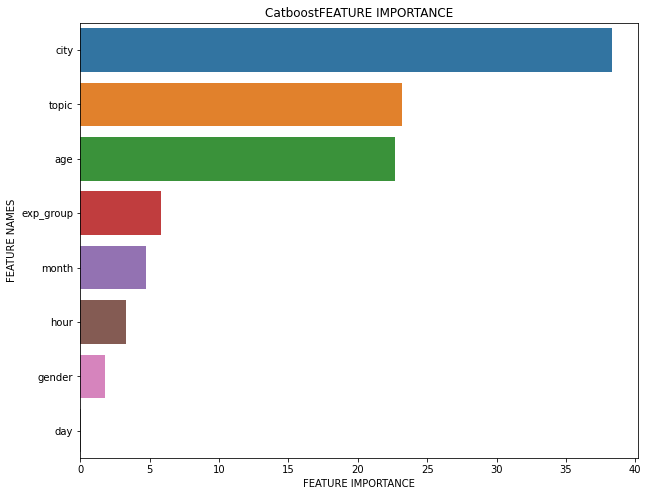

In [21]:
plot_feature_importance(catboost.feature_importances_,X_train.columns,'Catboost')